# BCN model

In [1]:
!pip install numpy
!pip install torchtext
!pip install torch
!pip install sklearn
!pip install bokeh
!pip install matplotlib

In [2]:
import numpy as np

from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors

import torch
from torch.autograd import Variable, Function
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear
from torch.nn.functional import softmax, relu, tanh
from torchtext.vocab import Vectors, GloVe, CharNGram, FastText
from torch.nn.utils.rnn import pack_padded_sequence as pack
from torch.nn.utils.rnn import pad_packed_sequence as unpack
from torch.nn.utils.rnn import pad_sequence as pad

import matplotlib.pyplot as plt


from sklearn.manifold import TSNE

from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.io import output_notebook, show, push_notebook
output_notebook()


Loading BokehJS ...

In [0]:
use_cuda = torch.cuda.is_available()

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x

def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

In [0]:

class Maxout(Function):

    # Note that both forward and backward are @staticmethods
    @staticmethod
    # bias is an optional argument
    def forward(ctx, input):
        x = input
        max_out=4    #Maxout Parameter
        kernels = x.shape[1]  # to get how many kernels/output
        feature_maps = int(kernels / max_out)
        out_shape = (x.shape[0], feature_maps, max_out)
        x= x.view(out_shape)
        y, indices = torch.max(x[:, :, :], 2)
        ctx.save_for_backward(input)
        ctx.indices=indices
        ctx.max_out=max_out
        return y

    # This function has only a single output, so it gets only one gradient
    @staticmethod
    def backward(ctx, grad_output):
        input1,indices,max_out= ctx.saved_variables[0],Variable(ctx.indices),ctx.max_out
        input=input1.clone()
        for i in range(max_out):
            a0=indices==i
            input[:,i:input.data.shape[1]:max_out]=a0.float()*grad_output
      

        return input

## SST

In [0]:
TEXT = data.Field(sequential=True,include_lengths=True)
LABEL = data.Field(sequential=False)

train_set, validation_set, test_set = datasets.SST.splits(TEXT,
                                                          LABEL,
                                                          fine_grained=False,
                                                          train_subtrees=True,
                                                          filter_pred=lambda ex: ex.label != 'neutral')

In [6]:
print('train.fields', train_set.fields)
print('len(train)', len(train_set))
print('vars(train[0])', vars(train_set[0]))
print()
print('Example 2', vars(train_set[17]))

train.fields {'text': <torchtext.data.field.Field object at 0x7f8ed1d3ed30>, 'label': <torchtext.data.field.Field object at 0x7f8ed1d3ec18>}
len(train) 98794
vars(train[0]) {'text': ['The', 'Rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'Century', "'s", 'new', '``', 'Conan', "''", 'and', 'that', 'he', "'s", 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'Arnold', 'Schwarzenegger', ',', 'Jean-Claud', 'Van', 'Damme', 'or', 'Steven', 'Segal', '.'], 'label': 'positive'}

Example 2 {'text': ['The', 'gorgeously', 'elaborate', 'continuation', 'of', '``', 'The', 'Lord', 'of', 'the', 'Rings', "''", 'trilogy', 'is', 'so', 'huge', 'that', 'a', 'column', 'of', 'words', 'can', 'not', 'adequately', 'describe', 'co-writer\\/director', 'Peter', 'Jackson', "'s", 'expanded', 'vision', 'of', 'J.R.R.', 'Tolkien', "'s", 'Middle-earth', '.'], 'label': 'positive'}


In [7]:
# build the vocabulary
url = 'https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.simple.vec'
#url = 'http://nlp.stanford.edu/data/glove.840B.300d.zip'
#TEXT.build_vocab(train_set, max_size=None, vectors=Vectors('wiki.simple.vec', url=url))
TEXT.build_vocab(train_set,vectors=GloVe(name='840B',dim='300'))

LABEL.build_vocab(train_set)
# print vocab information
print('len(TEXT.vocab)', len(TEXT.vocab))
print('TEXT.vocab.vectors.size()', TEXT.vocab.vectors.size())


len(TEXT.vocab) 18003
TEXT.vocab.vectors.size() torch.Size([18003, 300])


In [0]:
# make iterator for splits
train_iter, val_iter, test_iter = data.Iterator.splits(
    (train_set, validation_set, test_set), batch_size=32, sort_key=lambda x: len(x.text),sort_within_batch=True, repeat=False)


# print batch information
batchsst = next(iter(train_iter))

In [16]:
embedding_dim = TEXT.vocab.vectors.size()[1]
num_embeddings = TEXT.vocab.vectors.size()[0]
num_classes = len(LABEL.vocab.itos)

dropout_rate = 0.4

input_dim = 100

con_dim = 200

hidden_dim = 300

def dyn_Linear (in_features,out_features):
    return Linear(in_features = in_features, out_features = out_features, bias = False)
def dyn_batchnorm(num_features):
    return nn.BatchNorm1d(num_features)

# build the model
class BCNNet(nn.Module):

    def __init__(self):
        super(BCNNet, self).__init__()
        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)
        # use pretrained embeddings
        self.embeddings.weight.data.copy_(TEXT.vocab.vectors)
        
        # The ReLu activtion layer
        self.input = Linear(in_features = embedding_dim,
                            out_features = embedding_dim,
                             bias = False)
        
        # bilstm encoder
        self.bilstm_enc = nn.LSTM(input_size = embedding_dim,
                                  hidden_size = embedding_dim,
                                  batch_first = False,
                                  bidirectional = True)
        
        # bilstm integrator
        self.bilstm_int = nn.LSTM(input_size = embedding_dim*3*2,
                                  hidden_size = embedding_dim,
                                  batch_first = False,
                                  bidirectional = True)
        
        self.attnx = Linear(in_features=embedding_dim*2,
                              out_features = embedding_dim*2)
        self.attny = Linear(in_features=embedding_dim*2,
                              out_features = embedding_dim*2)
        
        #Pooling
        self.maxpool = nn.MaxPool1d(kernel_size = embedding_dim)
        self.avgpool = nn.AvgPool1d(kernel_size = embedding_dim)
                
        # maxout layer  
        self.batch = nn.BatchNorm1d(num_features=8)
        
        self.maxout = Linear(in_features = 8,
                                out_features = 8*2*2)
        
        
        self.mo1 = Maxout.apply
        self.mo2 = Maxout.apply
        self.mo3 = Maxout.apply
        
        self.out = Linear(in_features = 8,
                            out_features = num_classes,
                             bias = False)

        self.drop = nn.Dropout(p = dropout_rate)
        
    def forward(self, x, y):
        out = {}
        x_text, x_len = x
        y_text, y_len = y
        
        # Sorting tensors
        x_len, idx_sort = np.sort(x_len)[::-1],np.argsort(-x_len)
        x_text = x_text.index_select(1,torch.LongTensor(idx_sort))
        y_len, idx_sort = np.sort(y_len)[::-1],np.argsort(-y_len)
        y_text = y_text.index_select(1,torch.LongTensor(idx_sort))
        
        # Embedding
        x = self.embeddings(x_text)
        y = self.embeddings(y_text)
        
        # Relu
        x = relu(self.input(x))
        y = relu(self.input(y))

        # Encoder
        # Packing padded sequences to max_length
        packed_x = pack(x,x_len.copy(), batch_first = False)
        packed_y = pack(y,y_len.copy(), batch_first = False)
        # biLSTM
        x, hidenc_fx = self.bilstm_enc(x)
        y, hidenc_fy = self.bilstm_enc(y)
        xt = hidenc_fx[0]
        yt = hidenc_fy[0]
        # Unsorting
        idx_unsort = np.argsort(idx_sort)
        xt1 = xt[0].index_select(0,torch.LongTensor(idx_unsort))
        xt2 = xt[1].index_select(0,torch.LongTensor(idx_unsort))

        yt1 = yt[0].index_select(0,torch.LongTensor(idx_unsort))
        yt2 = yt[1].index_select(0,torch.LongTensor(idx_unsort))
        

        X = torch.cat((xt1,xt2),1) 
        Y = torch.cat((yt1,yt2),1)
        X = X.view(1,X.size()[0],X.size()[1])
        Y = Y.view(1,Y.size()[0],Y.size()[1])
        
        # Biattention
        #dim 1 = len, dim 2 = dim, and they are swaped so we can multiply the matrices
        A = torch.matmul(X, Y.transpose(1,2)) # A = X * Y^T  x = bs, len, dim, y^T = bs,dim, len
        A_x = softmax(A, dim=2) # A_x = softmax(A)
        A_y = softmax(A.transpose(1,2), dim=2) # A_y = softmax(A^T)
        C_x = torch.matmul(A_x.transpose(1,2), X) # C_x = A_x^T * X 
        C_y = torch.matmul(A_y.transpose(1,2), Y) # C_y = A_y^T * Y
        
        # Integrator
        # input for integrator bilstm
        
        x = torch.cat((X, X-C_y, torch.mul(X, C_y)), 2) # Concat([X; X-C_y; X.C_y])
        y = torch.cat((Y, Y-C_x, torch.mul(Y, C_x)), 2) # Concat([Y; Y-C_x; Y.C_x]
        # X_|y = biLSTM(%), Y|x = biLSTM(%)
        
            
        X_y, hidint_x = self.bilstm_int(x)
        Y_x, hidint_y = self.bilstm_int(y)
        
        X_temp = hidint_x[0]
        X_temp = torch.cat((X_temp[0],X_temp[1]),1)
        hidint_x = X_temp.view(1,X_temp.size()[0],X_temp.size()[1])
        
        Y_temp = hidint_y[0]
        Y_temp = torch.cat((Y_temp[0],Y_temp[1]),1)
        hidint_y = Y_temp.view(1,Y_temp.size()[0],Y_temp.size()[1])
       
        X_y = hidint_x
        Y_x = hidint_y
        
       
        
        # Pooling
        x_maxpool = self.maxpool(X_y)
        x_meanpool = self.avgpool(X_y)      
        x_minpool = X_y * -1
        x_minpool = self.maxpool(x_minpool)
        x_minpool = x_minpool * -1
        x_pool = torch.cat((x_maxpool, x_meanpool), 2)
       # print(x_pool.size())
        
      #  print(x_pool.size())
        
        y_maxpool = self.maxpool(Y_x)
        y_meanpool = self.avgpool(Y_x)
        y_minpool = Y_x * -1
        y_minpool = self.maxpool(y_minpool)
        y_minpool = y_minpool * -1
        y_pool = torch.cat((y_maxpool, y_meanpool), 2)
        
        # Maxout layer
        # And batchnormilization
        # Joined representations is the concatination of x_pool and y_pool
        joined = torch.cat((x_pool, y_pool), 2)
        joined = torch.squeeze(joined,0)

        joined = self.mo1(self.maxout(joined))
        
        joined = self.mo2(self.maxout(joined))
        
        joined = self.mo3(self.maxout(joined))
        joined = self.batch(joined)
        
        # 3rd maxout layer will be output
        out['out'] = softmax(self.out(joined), dim=1)
        return out

net = BCNNet()
print(net)

BCNNet(
  (embeddings): Embedding(18003, 300)
  (input): Linear(in_features=300, out_features=300, bias=False)
  (bilstm_enc): LSTM(300, 300, bidirectional=True)
  (bilstm_int): LSTM(1800, 300, bidirectional=True)
  (attnx): Linear(in_features=600, out_features=600, bias=True)
  (attny): Linear(in_features=600, out_features=600, bias=True)
  (maxpool): MaxPool1d(kernel_size=300, stride=300, padding=0, dilation=1, ceil_mode=False)
  (avgpool): AvgPool1d(kernel_size=(300,), stride=(300,), padding=(0,))
  (batch): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxout): Linear(in_features=8, out_features=32, bias=True)
  (out): Linear(in_features=8, out_features=3, bias=False)
  (drop): Dropout(p=0.4)
)


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0003,amsgrad=True,weight_decay=0.00001)

def accuracy(ys, ts):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = torch.eq(torch.max(ys, 1)[1], ts)
    # averaging the one-hot encoded vector
    return torch.mean(correct_prediction.float())

## TRAINING BCN WITH SST

In [18]:
eval_every = 500
log_every = 200

train_loss, train_accs, train_iter_list = [], [], []
train_loss_list, train_accs_list = [],[]
val_loss_list, val_accs_list, val_iter_list = [],[], []


max_acc = 0
max_acc_idx = 0
epochs = 1
reached_max = False

net.train()
while reached_max == False:
    print("EPOCH NR: " + str(epochs))
    for i, batch in enumerate(train_iter):
        if i % eval_every == 0:
            net.eval()
            val_losses, val_accs, val_lengths = 0, 0, 0
      #  val_meta = {'label_idx': [], 'sentences': [], 'labels': []}
            for val_batch in val_iter:
                output = net(val_batch.text,val_batch.text)
            # batches sizes might vary, which is why we cannot just mean the batch's loss
            # we multiply the loss and accuracies with the batch's size,
            # to later divide by the total size
                val_losses += criterion(output['out'], val_batch.label) * val_batch.batch_size
                val_accs += accuracy(output['out'], val_batch.label) * val_batch.batch_size
                val_lengths += val_batch.batch_size
            

        
        # divide by the total accumulated batch sizes
            val_losses /= val_lengths
            val_accs /= val_lengths
        
            val_loss_list.append(get_numpy(val_losses))
            val_accs_list.append(get_numpy(val_accs))
            val_iter_list.append(i)
        
            print("valid, it: {} loss: {:.2f} accs: {:.2f}\n".format(i, get_numpy(val_losses), get_numpy(val_accs)))
        #update_plot(val_meta, 'bow', tsne_plot)
        
            net.train()
    
        output = net(batch.text,batch.text)
        batch_loss = criterion(output['out'], batch.label)
    
        train_loss.append(get_numpy(batch_loss))
        train_accs.append(get_numpy(accuracy(output['out'], batch.label)))
 
    
        optimizer.zero_grad()
        batch_loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(),max_norm=5)
        optimizer.step()
    
        if i % log_every == 0:        
            print("train, it: {} loss: {:.2f} accs: {:.2f}".format(i, 
                                                               np.mean(train_loss), 
                                                               np.mean(train_accs)))
        # reset
            train_loss_list.append(np.mean(train_loss))
            train_accs_list.append(np.mean(train_accs))    
            train_iter_list.append(i)
            train_loss, train_accs = [], []
    if max(val_accs_list[max_acc_idx:len(val_accs_list)]) > max_acc:
        max_acc = max(val_accs_list[max_acc_idx:len(val_accs_list)])
        max_acc_idx = np.argmax(max(val_accs_list[max_acc_idx:len(val_accs_list)]))
    else:
        print("Maximum validation accuracy: " + str(max_acc))
        reached_max = True
        break
    epochs += 1

EPOCH NR: 1
valid, it: 0 loss: 1.13 accs: 0.00



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'


train, it: 0 loss: 1.10 accs: 0.38
train, it: 200 loss: 0.98 accs: 0.76
train, it: 400 loss: 0.86 accs: 0.86
valid, it: 500 loss: 0.86 accs: 0.79

train, it: 600 loss: 0.79 accs: 0.87
train, it: 800 loss: 0.74 accs: 0.88
valid, it: 1000 loss: 0.77 accs: 0.80

train, it: 1000 loss: 0.72 accs: 0.88
train, it: 1200 loss: 0.70 accs: 0.88
train, it: 1400 loss: 0.70 accs: 0.87
valid, it: 1500 loss: 0.78 accs: 0.78

train, it: 1600 loss: 0.68 accs: 0.88
train, it: 1800 loss: 0.68 accs: 0.89
valid, it: 2000 loss: 0.76 accs: 0.80

train, it: 2000 loss: 0.67 accs: 0.90
train, it: 2200 loss: 0.66 accs: 0.90
train, it: 2400 loss: 0.66 accs: 0.90
valid, it: 2500 loss: 0.78 accs: 0.77

train, it: 2600 loss: 0.65 accs: 0.90
train, it: 2800 loss: 0.65 accs: 0.90
valid, it: 3000 loss: 0.77 accs: 0.78

train, it: 3000 loss: 0.66 accs: 0.89
EPOCH NR: 2
valid, it: 0 loss: 0.76 accs: 0.79

train, it: 0 loss: 0.66 accs: 0.90
train, it: 200 loss: 0.64 accs: 0.92
train, it: 400 loss: 0.64 accs: 0.92
valid, it

In [0]:
for i in range(int(len(train_iter_list)/(epochs)),len(train_iter_list)):
    if train_iter_list[i] == 0:
        train_iter_list[i] = train_iter_list[i-1]+1
        continue
    else:
        train_iter_list[i] = train_iter_list[i-1] + log_every


for i in range(int(len(val_iter_list)/epochs),len(val_iter_list)):
    if val_iter_list[i] == 0:
        val_iter_list[i] =val_iter_list[i-1]+1
        continue
    else:
        val_iter_list[i] = val_iter_list[i-1] + eval_every

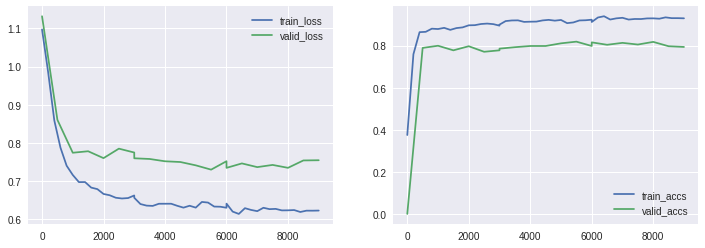

In [20]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(train_iter_list, train_loss_list, label='train_loss')
plt.plot(val_iter_list, val_loss_list, label='valid_loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_iter_list, train_accs_list, label='train_accs')
plt.plot(val_iter_list, val_accs_list, label='valid_accs')
plt.legend()
plt.show()

## SNLI

In [6]:
print("Run test on SNLI...")
TEXT = datasets.nli.ParsedTextField()
LABEL = data.LabelField()
TREE = datasets.nli.ShiftReduceField()

train, val, test = datasets.SNLI.splits(TEXT, LABEL, TREE)

print("Fields:", train.fields)
print("Number of examples:\n", len(train))
print("First Example instance:\n", vars(train[0]))

url = 'https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.simple.vec'
TEXT.build_vocab(train, max_size=None, vectors=Vectors('wiki.simple.vec', url=url))
#TEXT.build_vocab(train,vectors=GloVe[name='840B',dim='300'])
LABEL.build_vocab(train)


train_iter, val_iter, test_iter = data.Iterator.splits((train, val, test), batch_size=64,repeat = False)


print("Test iters function")

batch = next(iter(train_iter))
print("Numericalize premises:\n", batch.premise)
print("Numericalize hypotheses:\n", batch.hypothesis)
print("Entailment labels:\n", batch.label)


Run test on SNLI...
Fields: {'premise': <torchtext.datasets.nli.ParsedTextField object at 0x7fc84a575550>, 'premise_transitions': <torchtext.datasets.nli.ShiftReduceField object at 0x7fc84a575518>, 'hypothesis': <torchtext.datasets.nli.ParsedTextField object at 0x7fc84a575550>, 'hypothesis_transitions': <torchtext.datasets.nli.ShiftReduceField object at 0x7fc84a575518>, 'label': <torchtext.data.field.LabelField object at 0x7fc84a5756a0>}
Number of examples:
 549367
First Example instance:
 {'premise': ['A', 'person', 'on', 'a', 'horse', 'jumps', 'over', 'a', 'broken', 'down', 'airplane', '.'], 'premise_transitions': ['shift', 'shift', 'reduce', 'shift', 'shift', 'shift', 'reduce', 'reduce', 'reduce', 'shift', 'shift', 'shift', 'shift', 'shift', 'shift', 'reduce', 'reduce', 'reduce', 'reduce', 'reduce', 'shift', 'reduce', 'reduce'], 'hypothesis': ['A', 'person', 'is', 'training', 'his', 'horse', 'for', 'a', 'competition', '.'], 'hypothesis_transitions': ['shift', 'shift', 'reduce', 'shi

In [8]:
embedding_dim = TEXT.vocab.vectors.size()[1]
num_embeddings = TEXT.vocab.vectors.size()[0]
num_classes = len(LABEL.vocab.itos)

dropout_rate = 0.4

input_dim = 100

con_dim = 200

hidden_dim = 300


# build the model
class BCNNet(nn.Module):

    def __init__(self):
        super(BCNNet, self).__init__()
        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)
        # use pretrained embeddings
        self.embeddings.weight.data.copy_(TEXT.vocab.vectors)
        
        # The ReLu activtion layer
        self.input = Linear(in_features = embedding_dim,
                            out_features = embedding_dim,
                             bias = False)
        
        # bilstm encoder
        self.bilstm_enc = nn.LSTM(input_size = embedding_dim,
                                  hidden_size = embedding_dim,
                                  batch_first = False,
                                  bidirectional = True)
        
        # bilstm integrator
        self.bilstm_int = nn.LSTM(input_size = embedding_dim*3*2,
                                  hidden_size = embedding_dim,
                                  batch_first = False,
                                  bidirectional = True)
        
        self.attnx = Linear(in_features=embedding_dim*2,
                              out_features = embedding_dim*2)
        self.attny = Linear(in_features=embedding_dim*2,
                              out_features = embedding_dim*2)
        
        #Pooling
        self.maxpool = nn.MaxPool1d(kernel_size = embedding_dim)
        self.avgpool = nn.AvgPool1d(kernel_size = embedding_dim)
                
        # maxout layer  
        self.batch = nn.BatchNorm1d(num_features=8)
        
        self.maxout = Linear(in_features = 8,
                                out_features = 8*2*2)
        
        
        self.mo1 = Maxout.apply
        self.mo2 = Maxout.apply
        self.mo3 = Maxout.apply
        
        self.out = Linear(in_features = 8,
                            out_features = num_classes,
                             bias = False)

        self.drop = nn.Dropout(p = dropout_rate)
        
    def forward(self, x, y):
        out = {}
        x_text, x_len = x
        y_text, y_len = y
        
        # Sorting tensors
        x_len, idx_sort = np.sort(x_len)[::-1],np.argsort(-x_len)
        x_text = x_text.index_select(1,torch.LongTensor(idx_sort))
        y_len, idx_sort = np.sort(y_len)[::-1],np.argsort(-y_len)
        y_text = y_text.index_select(1,torch.LongTensor(idx_sort))
        
        # Embedding
        x = self.embeddings(x_text) # 3, 3, 300
        y = self.embeddings(y_text)
        
        # Relu
        x = relu(self.input(x))
        y = relu(self.input(y))

        # Encoder
        packed_x = pack(x,x_len.copy(), batch_first = False)
        packed_y = pack(y,y_len.copy(), batch_first = False)
        # biLSTM
        x, hidenc_fx = self.bilstm_enc(x)
        y, hidenc_fy = self.bilstm_enc(y)
        xt = hidenc_fx[0]
        yt = hidenc_fy[0]
        # Unsorting
        idx_unsort = np.argsort(idx_sort)
        xt1 = xt[0].index_select(0,torch.LongTensor(idx_unsort))
        xt2 = xt[1].index_select(0,torch.LongTensor(idx_unsort))

        yt1 = yt[0].index_select(0,torch.LongTensor(idx_unsort))
        yt2 = yt[1].index_select(0,torch.LongTensor(idx_unsort))

        X = torch.cat((xt1,xt2),1) # 1, 3, 600
        Y = torch.cat((yt1,yt2),1)
        X = X.view(1,X.size()[0],X.size()[1])
        Y = Y.view(1,Y.size()[0],Y.size()[1])

        
        # Biattention
        A = torch.matmul(X, Y.transpose(1,2)) # A = X * Y^T  x = bs, len, dim, y^T = bs,dim, len
        A_x = softmax(A, dim=2) # A_x = softmax(A)
        A_y = softmax(A.transpose(1,2), dim=2) # A_y = softmax(A^T)
        C_x = torch.matmul(A_x.transpose(1,2), X) # C_x = A_x^T * X 
        C_y = torch.matmul(A_y.transpose(1,2), Y) # C_y = A_y^T * Y
        
        # Integrator
        # input for integrator bilstm
        
        x = torch.cat((X, X-C_y, torch.mul(X, C_y)), 2) # Concat([X; X-C_y; X.C_y])
        y = torch.cat((Y, Y-C_x, torch.mul(Y, C_x)), 2) # Concat([Y; Y-C_x; Y.C_x]
        
            
        X_y, hidint_x = self.bilstm_int(x)
        Y_x, hidint_y = self.bilstm_int(y)
        
        X_temp = hidint_x[0]
        X_temp = torch.cat((X_temp[0],X_temp[1]),1)
        hidint_x = X_temp.view(1,X_temp.size()[0],X_temp.size()[1])
        
        Y_temp = hidint_y[0]
        Y_temp = torch.cat((Y_temp[0],Y_temp[1]),1)
        hidint_y = Y_temp.view(1,Y_temp.size()[0],Y_temp.size()[1])
       
        X_y = hidint_x
        Y_x = hidint_y
        
        
        # Pooling
        x_maxpool = self.maxpool(X_y)
        x_meanpool = self.avgpool(X_y)      
        x_minpool = X_y * -1
        x_minpool = self.maxpool(x_minpool)
        x_minpool = x_minpool * -1
        x_pool = torch.cat((x_maxpool, x_meanpool), 2)
        
        y_maxpool = self.maxpool(Y_x)
        y_meanpool = self.avgpool(Y_x)
        y_minpool = Y_x * -1
        y_minpool = self.maxpool(y_minpool)
        y_minpool = y_minpool * -1
        y_pool = torch.cat((y_maxpool, y_meanpool), 2)
        
        # Maxout layer
        # With dropout and batchnormilization
        # Joined representations is the concatination of x_pool and y_pool
        joined = torch.cat((x_pool, y_pool), 2)
        joined = torch.squeeze(joined,0)

        joined = self.mo1(self.maxout(joined))
 
        joined = self.mo2(self.maxout(joined))
        
        joined = self.mo3(self.maxout(joined))
        joined = self.batch(joined)
        
        # 3rd maxout layer will be output
        out['out'] = softmax(self.out(joined), dim=1)
        return out

net = BCNNet()
print(net)

BCNNet(
  (embeddings): Embedding(42392, 300)
  (input): Linear(in_features=300, out_features=300, bias=False)
  (bilstm_enc): LSTM(300, 300, bidirectional=True)
  (bilstm_int): LSTM(1800, 300, bidirectional=True)
  (attnx): Linear(in_features=600, out_features=600, bias=True)
  (attny): Linear(in_features=600, out_features=600, bias=True)
  (maxpool): MaxPool1d(kernel_size=300, stride=300, padding=0, dilation=1, ceil_mode=False)
  (avgpool): AvgPool1d(kernel_size=(300,), stride=(300,), padding=(0,))
  (batch): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxout): Linear(in_features=8, out_features=32, bias=True)
  (out): Linear(in_features=8, out_features=3, bias=False)
  (drop): Dropout(p=0.4)
)


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.003,amsgrad=True,weight_decay=0.00001)

def accuracy(ys, ts):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = torch.eq(torch.max(ys, 1)[1], ts)
    # averaging the one-hot encoded vector
    return torch.mean(correct_prediction.float())

In [0]:
eval_every = 1000
log_every = 200

train_loss, train_accs, train_iter_list = [], [], []
train_loss_list, train_accs_list = [],[]
val_loss_list, val_accs_list, val_iter_list = [],[], []


max_acc = 0
max_acc_idx = 0
epochs = 1
reached_max = False

net.train()
while epochs <= 5:
    print("EPOCH NR: " + str(epochs))
    for i, batch in enumerate(train_iter):
        if i % eval_every == 0:
            net.eval()
            val_losses, val_accs, val_lengths = 0, 0, 0
      #  val_meta = {'label_idx': [], 'sentences': [], 'labels': []}
            for val_batch in val_iter:
                output = net(val_batch.premise,val_batch.hypothesis)
            # batches sizes might vary, which is why we cannot just mean the batch's loss
            # we multiply the loss and accuracies with the batch's size,
            # to later divide by the total size
                val_losses += criterion(output['out'], val_batch.label) * val_batch.batch_size
                val_accs += accuracy(output['out'], val_batch.label) * val_batch.batch_size
                val_lengths += val_batch.batch_size
            

        
        # divide by the total accumulated batch sizes
            val_losses /= val_lengths
            val_accs /= val_lengths
        
            val_loss_list.append(get_numpy(val_losses))
            val_accs_list.append(get_numpy(val_accs))
            val_iter_list.append(i)
        
            print("valid, it: {} loss: {:.2f} accs: {:.2f}\n".format(i, get_numpy(val_losses), get_numpy(val_accs)))
        #update_plot(val_meta, 'bow', tsne_plot)
        
            net.train()
    
        output = net(batch.premise,batch.hypothesis)
        batch_loss = criterion(output['out'], batch.label)
    
        train_loss.append(get_numpy(batch_loss))
        train_accs.append(get_numpy(accuracy(output['out'], batch.label)))
 
    
        optimizer.zero_grad()
        batch_loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(),max_norm=5)
        optimizer.step()
    
        if i % log_every == 0:        
            print("train, it: {} loss: {:.2f} accs: {:.2f}".format(i, 
                                                               np.mean(train_loss), 
                                                               np.mean(train_accs)))
        # reset
            train_loss_list.append(np.mean(train_loss))
            train_accs_list.append(np.mean(train_accs))    
            train_iter_list.append(i)
            train_loss, train_accs = [], []
    if max(val_accs_list[max_acc_idx:len(val_accs_list)]) > max_acc:
        max_acc = max(val_accs_list[max_acc_idx:len(val_accs_list)])
        max_acc_idx = np.argmax(max(val_accs_list[max_acc_idx:len(val_accs_list)]))
    else:
        print("Maximum validation accuracy: " + str(max_acc))
        reached_max = True
        break
    epochs += 1
        

EPOCH NR: 1


In [0]:
for i in range(int(len(train_iter_list)/(epochs)),len(train_iter_list)):
    if train_iter_list[i] == 0:
        train_iter_list[i] = train_iter_list[i-1]+1
        continue
    else:
        train_iter_list[i] = train_iter_list[i-1] + log_every


for i in range(int(len(val_iter_list)/epochs),len(val_iter_list)):
    if val_iter_list[i] == 0:
        val_iter_list[i] =val_iter_list[i-1]+1
        continue
    else:
        val_iter_list[i] = val_iter_list[i-1] + eval_every

In [0]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(train_iter_list, train_loss_list, label='train_loss')
plt.plot(val_iter_list, val_loss_list, label='valid_loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_iter_list, train_accs_list, label='train_accs')
plt.plot(val_iter_list, val_accs_list, label='valid_accs')
plt.legend()
plt.show()